# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

#### Expect a environment variable ICDIR pointing to the IC root directory

In [6]:
ic = %env ICDIR

In [7]:
ic

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC'

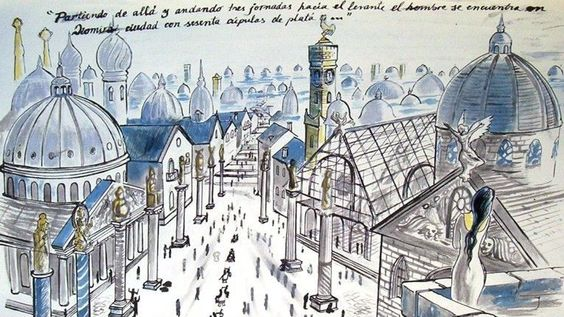

In [8]:
Image(filename=ic+'/Images/Diomira.jpg') 

## DIOMIRA notebook 

DIOMIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC

In [9]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import tables 
import numpy as np

In [11]:
from Configure import configure
from Nh5 import *
from cities import diomira
from SensorsResponse import *
import FEParam as FP

In [12]:
import mplFunctions as mpl
import wfmFunctions as wfm
from Util import *

#### DIOMIRA.py

In [13]:
"""
ChangeLog:

26.9 

Changed types of PMTRWF, SIPMRWF and PMTTWF to Float32 for 
    (compatibility with ART/GATE)

Do not store EPMT and ESIPM (can be computed on the fly)

Change sign of pmtrwf to negative (as produced by the DAQ)
"""

def DIOMIRA(argv):
    DEBUG_LEVEL, INFO, CFP = configure(argv[0],argv[1:])
   
    if INFO:
        print(diomira)

    #wait()
    
    print("""
        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        """)
    FP.print_FEE()
    #wait()

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    NEVENTS = LAST_EVT - FIRST_EVT

    print('Debug level = {}'.format(DEBUG_LEVEL))

    logger.info("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    logger.info("Compression library = {} Compression level = {} ".format(
        CLIB,CLEVEL))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r+") as h5in: 
        # access the PMT raw data in file 

        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)
        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        logger.info("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))

        #wait()

        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        
        # open the output file 
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib=CLIB, complevel=CLEVEL)) as h5out:
 
            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",
                           tables.Filters(0))

            # fill table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")
            
            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            
            # create an extensible array to store the TWF waveforms
            pmttwf = h5out.create_earray(h5out.root.RD, "pmttwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NSIPM, SIPMWL), 
                                    expectedrows=NEVENTS_DST)

            # #create an extensible array to store the energy in PES of PMTs 
            # epmt = h5out.create_earray(h5out.root.RD, "epmt", 
            #                         atom=tables.FloatAtom(), 
            #                         shape=(0, NPMT), 
            #                         expectedrows=NEVENTS_DST)

            # # create an extensible array to store the energy in PES of SiPMs 
            # esipm = h5out.create_earray(h5out.root.RD, "esipm", 
            #                         atom=tables.FloatAtom(), 
            #                         shape=(0, NSIPM), 
            #                         expectedrows=NEVENTS_DST)

            
            if NEVENTS > NEVENTS_DST and RUN_ALL == False:
                print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
                sys.exit(0)
            elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
                FIRST_EVT = 0
                LAST_EVT = NEVENTS_DST
                NEVENTS = NEVENTS_DST


            for i in range(FIRST_EVT,LAST_EVT):
                logger.info("-->event number ={}".format(i))

                #simulate PMT response and return an array with RWF
                dataPMT = simulate_pmt_response(i,pmtrd_)

                #convert to float
                dataPMT.astype(float) 
                #TWF
                 
                truePMT = rebin_signal(i,pmtrd_, int(FP.time_DAQ))
                truePMT.astype(float)
                
                logger.info("truePMT shape ={}".format(truePMT.shape))
                logger.info("dataPMT shape ={}".format(dataPMT.shape))
                
                #RWF for pmts
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                
                #TWF for pmts
                pmttwf.append(truePMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                   
                #simulate SiPM response and return an array with new WF
                dataSiPM = simulate_sipm_response(i,sipmrd_)
                dataSiPM.astype(float)
                
                #append to SiPM EARRAY
                sipmrwf.append(dataSiPM.reshape(1, NSIPM, SIPMWL))

                # #fill ene_pmt vector
                # enePMT = energy_pes(i, pmtrd_)
                # #append to epmt EARRAY
                # epmt.append(enePMT.reshape(1, NPMT))

                # #fill ene_sipm vector
                # eneSIPM = energy_pes(i, sipmrd_)
                # esipm.append(eneSIPM.reshape(1, NSIPM))

            pmtrwf.flush()
            pmttwf.flush()
            sipmrwf.flush()
            #epmt.flush()
            #esipm.flush()


    print("Leaving Diomira. Safe travels!")


### Configuration file

In [14]:
%less ../../Config/DIOMIRA_NA_ZLIB_test2.csv

####  DIOMIRA main

In [15]:
DIOMIRA(["DIOMIRA",'-i','-d','INFO','-c',ic+'/Config/DIOMIRA_NA_ZLIB_test2.csv'])

INFO:root:Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 3, 'FILE_OUT': 'WF_Na_ZLIB_test3_RWF.h5', 'PATH_OUT': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', ' END ': 1, 'CLIB': 'zlib', 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/', 'CLEVEL': 1, 'FILE_IN': 'WF_Na_1Kevts_comp1_chunk32k.h5'}


Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 3, 'FILE_OUT': 'WF_Na_ZLIB_test3_RWF.h5', 'PATH_OUT': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', ' END ': 1, 'CLIB': 'zlib', 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/', 'CLEVEL': 1, 'FILE_IN': 'WF_Na_1Kevts_comp1_chunk32k.h5'}



Leaving there and proceeding for three days toward the east, you reach Diomira, 
a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, 
a crystal theater, a golden cock that crows every morning on a tower. 
All these beauties will already be familiar to the visitor, 
who has seen them also in other cities. 
But the special quality of this city for the man who arrives there on a September evening, 
when the days are growing shorter 
and the multicolored lamps are lighted all at once at the doors of the food stalls 
and from a terrace a woman's voice cries ooh!, is that he feels envy 
toward those who now believe they have once before lived an 
evening identical to this and who think they were happy, that time.

        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in

input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/WF-NA-ZLIB/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_1Kevts_comp1_chunk32k.h5 file_out =WF_Na_ZLIB_test3_RWF.h5


INFO:root:first event = 0 last event = 3 nof events requested = 3 


first event = 0 last event = 3 nof events requested = 3 


INFO:root:Compression library = zlib Compression level = 1 


Compression library = zlib Compression level = 1 


INFO:root:nof PMTs = 12 nof  SiPMs = 1792 nof events in input DST = 1000 


nof PMTs = 12 nof  SiPMs = 1792 nof events in input DST = 1000 


INFO:root:lof SiPM WF = 599999 lof PMT WF (MC) = 600 lof PMT WF (FEE) = 24000


lof SiPM WF = 599999 lof PMT WF (MC) = 600 lof PMT WF (FEE) = 24000


INFO:root:-->event number =0


-->event number =0


INFO:root:truePMT shape =(12, 24000)


truePMT shape =(12, 24000)


INFO:root:dataPMT shape =(12, 24000)


dataPMT shape =(12, 24000)


INFO:root:-->event number =1


-->event number =1


INFO:root:truePMT shape =(12, 24000)


truePMT shape =(12, 24000)


INFO:root:dataPMT shape =(12, 24000)


dataPMT shape =(12, 24000)


INFO:root:-->event number =2


-->event number =2


INFO:root:truePMT shape =(12, 24000)


truePMT shape =(12, 24000)


INFO:root:dataPMT shape =(12, 24000)


dataPMT shape =(12, 24000)


Leaving Diomira. Safe travels!


### Checking the file

In [16]:
ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test3_RWF.h5'

-rw-r--r--  1 jjgomezcadenas  staff   6.7M Sep 27 20:58 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test3_RWF.h5


In [17]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test10_RWF.h5')

In [18]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test10_RWF.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float64Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float64Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float64Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float64Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (1170,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "CO12": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32

In [18]:
pmttwf = h5f.root.RD.pmttwf

In [19]:
pmttwf

/RD/pmttwf (EArray(10, 12, 24000), shuffle, zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 24000)

In [20]:
pmt0 = pmttwf[0,0]

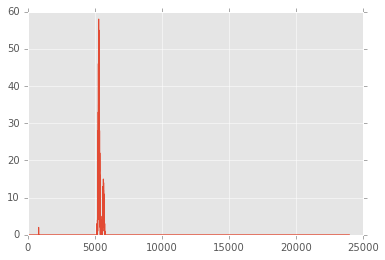

In [21]:
plt.plot(pmt0)

In [22]:
pmtrwf = h5f.root.RD.pmtrwf

In [23]:
pmtr0 = pmtrwf[0,0]

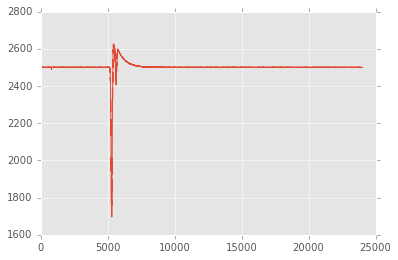

In [24]:
plt.plot(pmtr0)

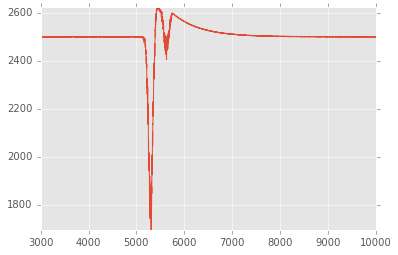

In [25]:
mpl.plts(pmtr0, signal_start=3000, signal_end=10000, offset=0)

In [26]:
sgn = 4096 - pmtr0

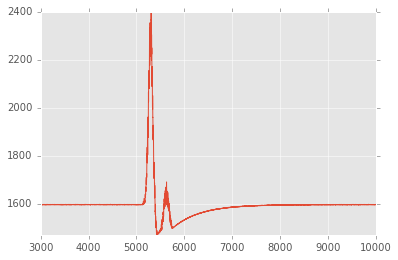

In [27]:
mpl.plts(sgn, signal_start=3000, signal_end=10000, offset=0)

In [28]:
sgnzs = sgn -1600

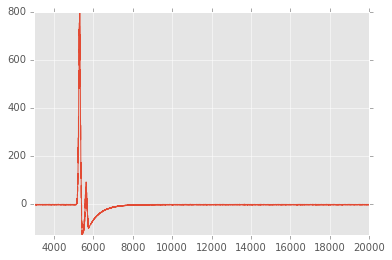

In [29]:
mpl.plts(sgnzs, signal_start=3000, signal_end=20000, offset=0)

In [33]:
h5f.close()

### Checking MC production 

In [36]:
%ls -lh /Users/jjgomezcadenas/Documents/Development/NEXT/data/test/

total 162832
-rw-r--r--  1 jjgomezcadenas  staff   1.6M Sep 26 21:07 nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next.root.h5
-rw-r--r--  1 jjgomezcadenas  staff    77M Sep 27 19:24 nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_1.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   1.1M Sep 26 22:05 run_2033.gdc1next.000.next1el.root.h5


In [37]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_1.root.h5')

In [38]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_1.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(10, 12, 11999), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 11999)
/sipmrd (EArray(10, 1792, 1200), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Tab

### Format of MC is not correct!

In [39]:
%ls -lh ../../../data/Waveforms/WF-NA-ZLIB/WF_Na_1Kevts_comp1_chunk32k.h5

-rw-r--r--@ 1 jjgomezcadenas  staff   232M Aug 14 20:31 ../../../data/Waveforms/WF-NA-ZLIB/WF_Na_1Kevts_comp1_chunk32k.h5


1. There is a problem with size. In a previous production we saw that events take about 230 kb (e.g, see 1k events take 232 M). Current file takes 77 M for 10 events, whih is 7.7 M per event. This is not possible.
2. /pmtrd (EArray(10, 12, 11999), zlib(1)) : size of the waveform is wrong! (should be 1200000) 
3. All the other fields appear to be correct

In [40]:
pmtrd = h5f.root.pmtrd

In [41]:
pmtrd

/pmtrd (EArray(10, 12, 11999), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 11999)

In [44]:
pmtr0 = pmtrd[0,0]

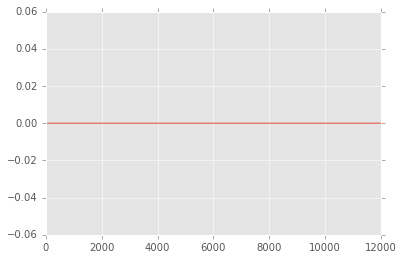

In [45]:
plt.plot(pmtr0)

Field is empty. 

In [46]:
h5f.close()

### Checking format of data

In [47]:
%ls -lh /Users/jjgomezcadenas/Documents/Development/NEXT/data/test/

total 166192
-rw-r--r--  1 jjgomezcadenas  staff   1.6M Sep 27 21:16 dst_run_2033.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   1.6M Sep 26 21:07 nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next.root.h5
-rw-r--r--  1 jjgomezcadenas  staff    77M Sep 27 19:24 nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_1.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   1.1M Sep 26 22:05 run_2033.gdc1next.000.next1el.root.h5


In [62]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/dst_run_2033.root.h5')

In [63]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/dst_run_2033.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtrwf (EArray(1, 12, 48000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/sipmrwf (EArray(1, 1215, 1200), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Sensors (Group) ''
/Sensors/DataPMT (Table(12,)) ''
 

In [64]:
pmtrwf = h5f.root.RD.pmtrwf

In [65]:
pmtrwf

/RD/pmtrwf (EArray(1, 12, 48000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)

In [66]:
pmtr0 = pmtrwf[0,0]

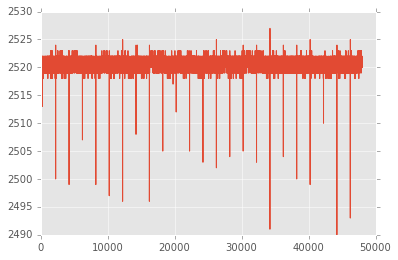

In [67]:
plt.plot(pmtr0)

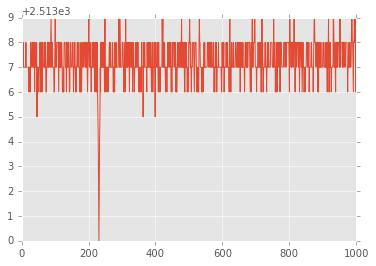

In [68]:
mpl.plts(pmtr0, signal_start=0, signal_end=1000, offset=0)

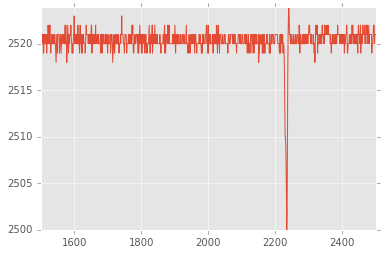

In [69]:
mpl.plts(pmtr0, signal_start=1500, signal_end=2500, offset=0)

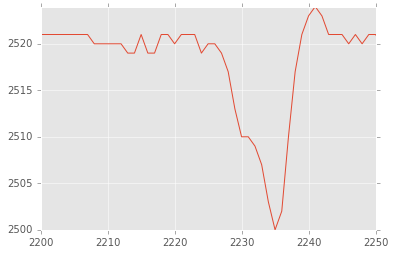

In [70]:
mpl.plts(pmtr0, signal_start=2200, signal_end=2250, offset=0)

In [71]:
sipmrwf = h5f.root.RD.sipmrwf
sipmwf = sipmrwf[0]

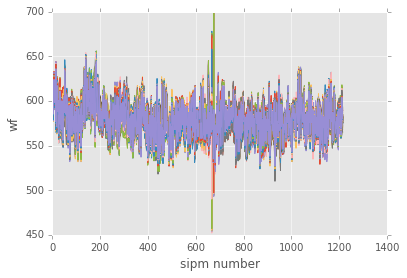

In [72]:
plt.plot(sipmwf)    
plt.xlabel('sipm number')
plt.ylabel('wf')

In [73]:
sipmwf2 = sipmwf[600:800]

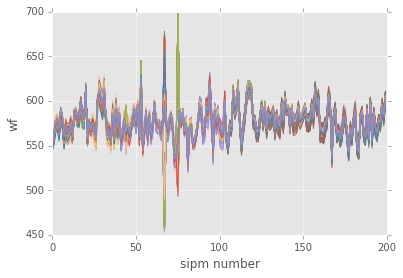

In [74]:
plt.plot(sipmwf2)    
plt.xlabel('sipm number')
plt.ylabel('wf')

### Data file appears to be correct

In [75]:
h5f.close()

### Plotting waveforms

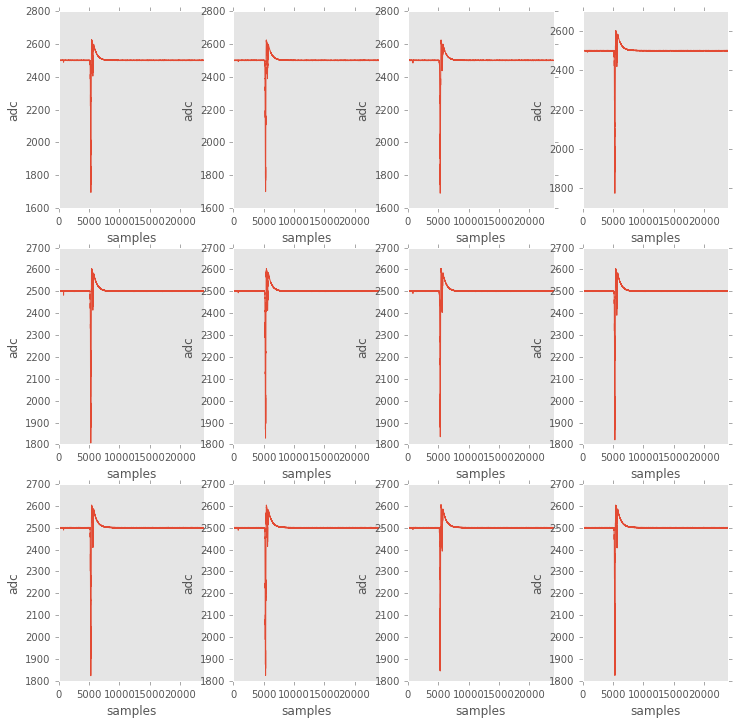

In [26]:
mpl.plot_waveforms(pmtrwf[0]) 

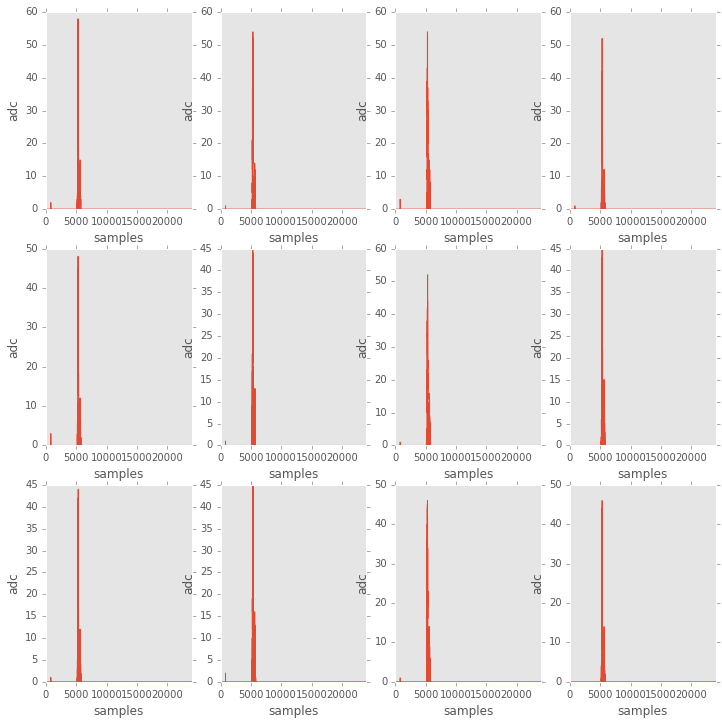

In [27]:
mpl.plot_waveforms(pmttwf[0]) 

In [28]:
h5f.close()

### Test run with 100 events

In [ ]:
import time

In [ ]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

In [ ]:
%less ../../Config/DIOMIRA_NA_ZLIB_test2.csv

In [ ]:
%time DIOMIRA(["DIOMIRA",'-d','INFO','-c',ic+'/Config/DIOMIRA_NA_ZLIB_test2.csv'])

### Status

In [ ]:
import time

In [ ]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

DIOMIRA running with ZLIB compression, offset set to 2500 and negative sign. 

In [ ]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_test100_RWF.h5')

In [ ]:
pmtrwf = h5f.root.RD.pmtrwf

In [ ]:
mpl.scan_waveforms(pmtrwf,list_of_events=[1,10,20,50,99])

In [ ]:
h5f.close()